In [1]:
%matplotlib inline
%precision 16
import numpy
from scipy.special import erf, fresnel
import matplotlib.pyplot as plt

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Kernel $\rightarrow$ Restart) and then run all cells (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says YOUR CODE HERE or "YOUR ANSWER HERE", as well as your name and collaborators below:

# HW 4:  Numerical  Quadrature 

## Question 1 - Basic  Quadrature Rules

The Error Function $\mathrm{erf}(x)$ is defined by the definite integral

$$
    \mathrm{erf}(x) = \frac{2}{\pi}\int_0^x e^{-t^2}dt
$$ 

We will use this function to test and understand the different errors associated with a range of both single interval and extended quadrature rules.  

Use the function definitions below to write a set of functions for approximating 
$$
 I[f] =  \int_a^b f(x) dx
$$ 
which we will use for testing against $\mathrm{erf}(x)$

**(a)** [8] Single step quadrature rules

Write short python functions for calculating $I[f]$ for the following newton-Cotes  quadrature rules on a single interval

* Left-Rectangle rule (a 1-point quadrature rule like  Mid-point, but evaluated at $x=a$, not the mid-point)
* Mid-point rule
* Trapezoidal rule
* Simpson's Rule

In [2]:
def I_left(f, a, b):
    """ Left rectangle rule"""
    return (b-a)*f(a)
    
def I_midpoint(f, a, b):
    """ Newton-Cotes Midpoint rule"""
    return (b-a)*f((a+b)/2)
    
def I_trapezoid(f, a, b):
    """ Newton-Cotes Midpoint rule"""
    return (b-a)*(f(a) + f(b))/2
    
def I_simpson(f, a, b):
    """ Newton-Cotes Simpsons rule"""
    return (b-a)*(f(a) + 4*f((a+b)/2) + f(b))/6

In [3]:
# test against erf(1.)

x = 1.0
I_true = erf(x)
print('x = {}, erf(x) = {}\n'.format(x,I_true))
f = lambda x : 2./numpy.sqrt(numpy.pi) * numpy.exp(-x*x)

I = numpy.zeros(4)
I[0] = I_left(f, 0., x)
I[1] = I_midpoint(f, 0., x)
I[2] = I_trapezoid(f, 0., x)
I[3] = I_simpson(f, 0., x)

err = numpy.abs( I - I_true)/numpy.abs(I_true)
answer = numpy.array([0.339003328982087,  0.0428168411464673,
          0.084202437312641, 0.0004770816600977])
numpy.testing.assert_allclose(err, answer)
print('success!')

x = 1.0, erf(x) = 0.8427007929497148

success!


**(b)** [8] Repeat the exercise for  3 point Gauss-Legendre Quadrature

* First:  calculate the weights $w_i$, using the method of undetermined coefficients such that the quadrature rule exactly integrates the monomials $1, x, x^2$ over the interval $x\in[-1,1]$.
(hint:  the 3 quadrature points $x_i$ are the roots of 

$$
    P_3(x) = (5x^3 - 3x)/2
$$
and this rule will exactly integrate polynomials up to order 5).

For $P_3(x) = \frac{(5x^2 - 3x)}{2}$, the roots are $x_1 = 0$, $x_2 = \sqrt{\frac{3}{5}}$, $x_3 = -\sqrt{\frac{3}{5}}$. 

The derivative of $P_3(x)$ is given by 
\begin{align*}
    P_3'(x) = \frac{15 x^2 - 3}{2}. 
\end{align*}

Weight $w_i$ is given by formula 
\begin{align*}
    w_i = \frac{2}{(1 - {x_i}^2) (P_3'(x_i))^2}
\end{align*}

Substituting the roots gives that $w_1 = \frac{8}{9}$, $w_2 = \frac{5}{9}$, $w_3 = \frac{5}{9}$. 

Next, implement your 3-point GL quadrature scheme to approximate 

$$
    \int_a^b f(x) dx
$$
for an arbitrary interval $x\in [a,b]$ (remember the affine mapping). 

In [4]:
def I_GL3(f, a, b):
    """ 3 point Gauss-Legendre Quadrature rule for an arbitrary interval x \in [a,b]"""
    x_hat = numpy.array([-numpy.sqrt(3./5.), 0., numpy.sqrt(3./5.)])
    w_hat = numpy.array([5./9., 8./9., 5./9.])
    x = 0.5*(b-a)*x_hat + 0.5*(b+a)
    w = 0.5*(b-a)*w_hat
    return numpy.dot(w, f(x))

In [5]:
x = 1.0
I_true = erf(x)
f = lambda x : 2./numpy.sqrt(numpy.pi) * numpy.exp(-x*x)

I = I_GL3(f, 0., x)
err = numpy.abs( I - I_true)/numpy.abs(I_true)
print('x = {}, erf(x) = {}'.format(x,I_true))
print('       I_GL3(x) = {}, err={}\n'.format(I,err))

answer = 1.2785635535382798e-05
numpy.testing.assert_allclose(err, answer)
print('success!')

x = 1.0, erf(x) = 0.8427007929497148
       I_GL3(x) = 0.8426900184845107, err=1.2785635535382798e-05

success!


**(c)** [8] Extended Quadrature rules. 

All of the above rules approximate the integral for a single "panel" over the interval $[a,b]$, but can be extended to calculate the quadrature of $N$ panels that subdivide the interval.  

Write a function that computes

$$
    I_N[f] = \int_a^b f(x) dx = \sum_{n=1}^N I_{method}[f]_n
$$


where $I_{method}[f]_n$ is one of the quadrature methods used above. 

Note, this won't be the most efficient way to implement many of these methods,  but that's not really the issue here.

In [6]:
def quadN(f, a, b, N, method=I_midpoint):
    """ 
    integrate a function f over the interval x in [a,b] using 
    an extended quadrature rule that implements a single interval
    quadrature rule over N panels of width (a - b)/N 
        
    Parameters:
    -----------
        
    f:  function f(x) (type float)
    a: float
        left boundary of interval
    b: float
        right boundary of interval
    N: integer
        number of panels to subdivide [a,b]
    method:  quadrature function with interface I(f, x0, x1) (real)
        returns quadrature approximation for subinterval [x0, x1]
        defaults to a midpoint rule
            
    Returns:
    --------
    I_N:  extended quadrature approximation of \int_a^b f(x) dx
        
    """
    h = (b - a)/N
    I_N = 0.
    for i in range(N):
        I_N += method(f, a + i*h, a + (i+1)*h)
    return I_N
    

In [7]:
# Let's test against erf(1)

x = 1.
I_true = erf(x)
f = lambda x : 2./numpy.sqrt(numpy.pi) * numpy.exp(-x*x)

# set the number of panels in a list
N = [ 2**n for n in range (5)]

# integrate using the extended mid-point scheme and calculate relative errors for each N
err = numpy.zeros(len(N))
for i,n in enumerate(N):
    I = quadN(f, 0., x, n, method=I_midpoint)
    err[i] = numpy.abs(I - I_true)/numpy.abs(I_true)
    print('N = {}, I = {}, err = {}'.format(n, I, err[i]) )
    
answer = numpy.array([0.0428168411464673, 0.0104091587540129,
                      0.0025749021678512, 0.0006419796806984,
                      0.0001603854223201])
numpy.testing.assert_allclose(answer,err)
print('success!')
                    

N = 1, I = 0.8787825789354448, err = 0.042816841146467305
N = 2, I = 0.8514725992856609, err = 0.010409158754012854
N = 4, I = 0.844870665048331, err = 0.00257490216785125
N = 8, I = 0.843241789735697, err = 0.0006419796806984446
N = 16, I = 0.8428359498722815, err = 0.00016038542232009014
success!


**(d)** [10] Now *write a function* to make a plot that  compares the convergence behavior of all of the above methods (if you make it a function, you will be able to reuse it in the next  problem).


This function should  make a single, beautiful log-log plot with the following information

* plot the *relative error* for each quadrature rule with respect to 
$$
    I_{true} = \mathrm{erf}(1) = 0.8427007929497148
$$
for 
$$
    N = 2^n \quad \text{panels}\quad \text{for}\, n=0,1,\ldots,10
$$

* a legend that labels each curve with the name of the method

Hint 1: there are some nice python tricks for doing this relatively efficiently, e.g. you can loop over a list of methods and extract the name with 

`name = method.__name__`


* the calculated rate of convergence of each  scheme. 

Note, if we define the convergence behavior of the error as
$$
    |e| = C\Delta x^p
$$

calculate $C$ and $p$ for each method and plot the best fit straight-line in $\log(\Delta x)-\log(e)$ space (hint: `numpy.polyfit` is your friend).  Add the best fit value of $p$ to the legend.  Hint 2: be careful not to include floating point issues in your fit. 

In [8]:
def plot_quad_convergence(f, a, b, N, I_true, title=None):
    """ create a convergence log-log plot that plots relative error of 
    various extended quadrature schemes vs panel spacing dx
    
    If really fancy, also calculates the best fit straight line in log-log space to estimate convergence
    parameters
    
    Parameters:
    -----------
        
    f:  function f(x) (type real)
    a: real
        left boundary of interval
    b: real
        right boundary of interval
    N: List of integers 
        number of panels to subdivide [a,b]
    I_true:  real
        True solution to compute errors
    title:  string
        title of plot (if not None)
            
    Returns:
    --------
    Nothing but generates a pretty log-log plot all properly labeled
    
    """
    
    color = ['r', 'b', 'g', 'k', 'm']
    
    for idx, method in enumerate([I_left, I_midpoint, I_trapezoid, I_simpson, I_GL3]):
        err = numpy.zeros(len(N))
        dx = numpy.zeros(len(N))
        for i,n in enumerate(N):
            dx[i] = (b - a)/n
            I = quadN(f, a, b, n, method)
            err[i] = numpy.abs(I - I_true)/numpy.abs(I_true)
        
        name = method.__name__
        p = numpy.polyfit(numpy.log(dx), numpy.log(err), 1)
        plt.loglog(dx, err, 'o', color = color[idx], label = name + ' p = {:.2f}'.format(p[0]))
        plt.loglog(dx, numpy.exp(p[1]) * dx**p[0], '--', color=color[idx])
        
    plt.xlabel('$\Delta x$')
    plt.ylabel('Relative Error')
    plt.title(title)    
    plt.legend()
    plt.show()

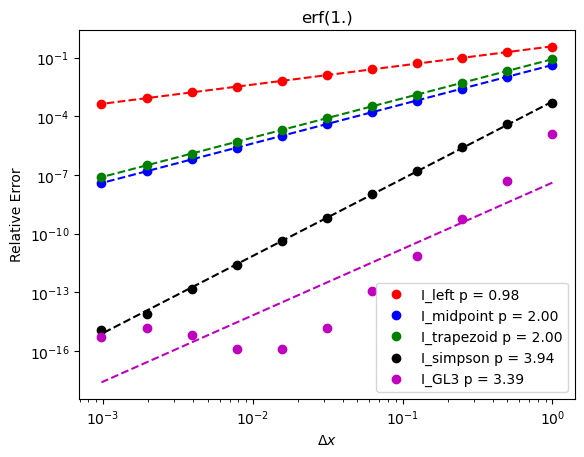

In [9]:
#Let's test with erf(1) and a lot of points

x = 1.
I_true = erf(x)
f = lambda x : 2./numpy.sqrt(numpy.pi) * numpy.exp(-x*x)    

N = [ 2**n for n in range (11)]

plot_quad_convergence(f, 0., 1., N, I_true, 'erf(1.)')

**(e)** [3] Estimate the number of *function evaluations* required to get a relative error $e \approx 10^{-7}$ i.e. about 7 digits of precision for the schemes

* Mid-point
* Simpson's
* 3-Pt GL quadrature


For mid-point method, to achieve $e \approx 10^{-7}$, we need $10^{-7} \approx (\Delta x)^2$, which gives $\Delta x \approx 10^{-7/2}$. The number of evaluations equal to $\frac{1}{\Delta x} \approx 3162$. 

For Simpson's method, we need $10^{-7} \approx (\Delta x)^{3.94}$, which gives $\Delta x \approx 0.0167$. The number of evaluations equal to $\frac{1}{\Delta x} \approx 60$. 

For 3-pt GL quadrature method, we need $10^{-7} \approx (\Delta x)^{3.39}$, which gives $\Delta x \approx 0.0086$. The number of evaluations equal to $\frac{1}{\Delta x} \approx 116$. 

## Question 2

Let's repeat the problem with a harder integral.

Consider the scaled Fresnel integrals

$$I_c = \int^1_0 \frac{\cos x}{\sqrt{x}} dx~~~~\text{and}~~~~I_s = \int^1_0 \frac{\sin x}{\sqrt{x}} dx$$

which have values

$$I_c = \sqrt{2 \pi} \cdot C\left(\sqrt{\frac{2}{\pi}}\right) \approx 1.8090484758005438$$

$$I_s = \sqrt{2 \pi} \cdot S\left(\sqrt{\frac{2}{\pi}}\right) \approx 0.62053660344676231$$

where the functions $C(x)$ and $S(x)$ can be evaluated by `scipy.special.fresnel`.


**(a)** [2] Where do you imagine the problematic points of the integrals will be?

The value for both functions are undefined at $x = 0$ due to $\sqrt{x}$ in denominator. 

**(b)** [4] Use your convergence plotting routine to make  2 plots showing convergence behavior for all the extended quadrature rules for $I_c$ and $I_s$ 

In [10]:
# Set the True solutions for reference
Is_true, Ic_true = fresnel(numpy.sqrt(2.0 / numpy.pi))
Is_true *= numpy.sqrt(2.0 * numpy.pi)
Ic_true *= numpy.sqrt(2.0 * numpy.pi)

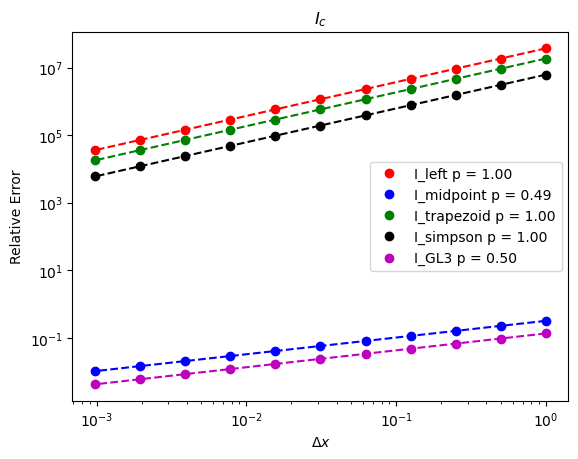

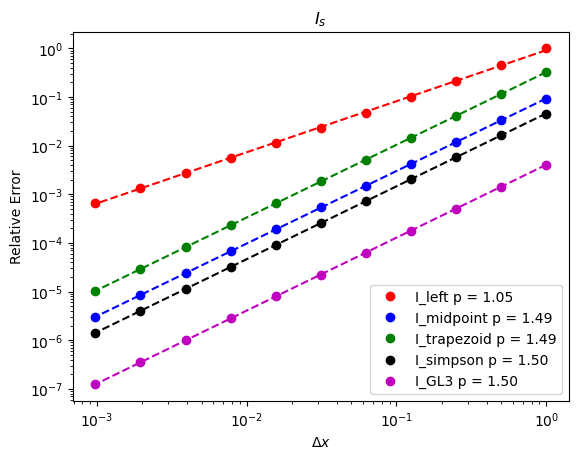

In [11]:
Ic = lambda x : numpy.cos(x) / numpy.sqrt(x)
Is = lambda x : numpy.sin(x) / numpy.sqrt(x)

plot_quad_convergence(Ic, numpy.finfo(float).eps, 1, N, Ic_true, '$I_c$')
plot_quad_convergence(Is, numpy.finfo(float).eps, 1, N, Is_true, '$I_s$')

**(c)**  [4] Explain the results of your plots

We can see that the extended quadrature rules do not work well for both functions, which might be due to the oscilation of trignometric functions. The result for $I_c$ is even poorer because $\frac{\cos(x)}{\sqrt{x}} \to \infty$ as $x \to 0^+$. So at the starting point near $0$, the predicted slope is really inaccurate. 

**(d)** [4] show that the convergence and the quadrature schemes can be dramatically improved simply by tranforming the variable $x$ with $x=t^2$

1. Show analytically what the transformed integral should be
2. produce two more plots demonstrating convergence behaviour
3. comment on the results

Using $x = t^2$, 
\begin{align*}
\int_0^1 \frac{\cos(x)}{\sqrt{x}} dx = \int_0^1 \frac{\cos(t^2)}{t} \cdot 2t dt = \int_0^1 2\cos(t^2) dt. 
\end{align*}

Similarly, 
\begin{align*}
\int_0^1 \frac{\sin(x)}{\sqrt{x}} dx = \int_0^1 \frac{\sin(t^2)}{t} \cdot 2t dt = \int_0^1 2\sin(t^2) dt. 
\end{align*}

C:\Users\31040\AppData\Local\Temp\ipykernel_35968\2045544808.py:40: RuntimeWarning: divide by zero encountered in log
  p = numpy.polyfit(numpy.log(dx), numpy.log(err), 1)


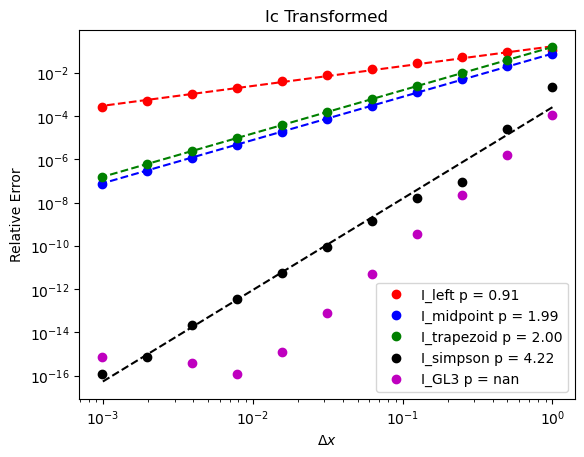

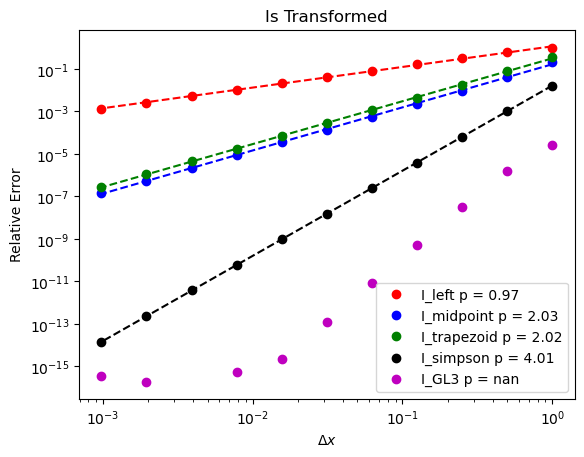

In [12]:
Ic_transformed = lambda x : 2 * numpy.cos(x**2)
Is_transformed = lambda x : 2 * numpy.sin(x**2)

plot_quad_convergence(Ic_transformed, 0, 1, N, Ic_true, 'Ic Transformed')
plot_quad_convergence(Is_transformed, 0, 1, N, Is_true, 'Is Transformed')

By introducing $x = t^2$, we could avoid dividing $\sqrt{x}$ in numerical evaluation, which prevents a large value occuring near $x = 0$ and affect the result of convergence. We can see on the graph that now we have a much higher convergence rate comparing with the original integral. 